<a href="https://colab.research.google.com/github/KurniaTanggang/prediksi_layak_air/blob/main/Prediksi%20Kelayakan%20Air.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kesehatan : Prediksi Kelayakan Air

## Business Understanding
Memprediksi air layak minum dan tidak layak minum dengan menggunakan beberapa parameter. Dari parameter tersebut, model machine learning akan mengklasifikasikan mana yang layak dan mana yang tidak layak sehingga dapat digunakan untuk memprediksi kelayakan air.

### Problem Staements
- Apa saja parameter yang paling berpengaruh terhadap kelayakan air minum ?
- Bagaiaman membuat model yang dapat memprediksi kelayakan air ?

### Goals
- Mengetahui parameter yang paling berpengaruh terhadap kelayakan air.
- Membuat model machine learning yang dapat memprediksi kelayakan air minum.

### Solution statements
Untuk dapat mengetahui kelayakan air, maka dibuatlah prediksi air layak minum dan tidak layak minum berdasarkan parameter pH, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, dan Potability dengan **Algoritma  Random Forest**. **Random Forest** termasuk ke dalam ensemble learning yang terdiri dari beberapa model yang bekerja bersamaan. Random forest tersusun dari banyak algoritma decision tree yang pembagian data dan fiturnya dipilih secara acak (random). 

Karena ini adalah kasus klasifikasi, maka akan digunakan Random Forest Classifier. Proses klasifikasi pada random forest berawal dari memecah data sampel yang ada kedalam decision tree secara acak. Setelah pohon terbentuk,maka akan dilakukan voting pada setiap kelas dari data sampel. Kemudian, mengkombinasikan vote dari setiap kelas kemudian diambil vote yang paling banyak.

Library yang dibutuhkan

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Data Understanding
Data yang akan digunakan adalah Dataset Water Potability yang diambil dari [Kaggle](https://www.kaggle.com/adityakadiwal/water-potability). 

### Data Loading
Load dataset water_potability

In [ ]:
data_air = pd.read_csv('water_potability.csv')
data_air

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


### Exploratory Data Analysis
Pada data air terdapat 3276 baris dan 10 kolom yaitu : 
1. ph : pH air (0 - 14)
2. Hardness : Kapasitar air untuk mengendapkan sabun (mg/L)
3. Solids : Total padatan terlarut (ppm)
4. Chloramines : Jumlah Chloramin (ppm)
5. Sulfate : Jumlah sulfat (mg/L)
6. Conductivity : Konduktivitas listrik pada air (μS/cm)
7. Organic_carbon : Jumlah organic carbon (ppm)
8. Trihalomethanes : Jumalah Trihalomethanes in (μg/L)
9. Turbidity : Kekeruhan
10. Potability : Kelayakan air. Layak = 1 dan tidak layak = 0
 
EDA adalah proses menganalisis karakteristik, menemukan pola, anomali, dan memeriksa asumsi pada data.



#### Deskripsi Variabel

In [ ]:
# mengecek informasi pada dataset
data_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Semua kolom merupakan kolom numerik. Kolom yang menjadi target adalah Potability dengan tipe data int64.

#### Missing value dan Keseimbangan Data
Mengecek missing value.

In [ ]:
data_air.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Menangani missing value dengan mengisi nilai yang kosong dengan nilai rata-rata.


In [ ]:
data_air['ph'].fillna(data_air['ph'].mean(), inplace=True)
data_air['Sulfate'].fillna(data_air['Sulfate'].mean(), inplace=True)
data_air['Trihalomethanes'].fillna(data_air['Trihalomethanes'].mean(), inplace=True)
print("Jumlah data_air = ", data_air.shape)
data_air.isnull().sum()

Jumlah data_air =  (3276, 10)


ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

Mengecek data sampel pada Potability

In [ ]:
data_air['Potability'].value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

Data potability mempunyai kesenjangan yang besar, sehingga perlu diseimbangkan untuk menghindari bias dengan menggunakan fungsi resample, concat dan shuffle.

In [ ]:
non_potable  = data_air[data_air['Potability']==0]   
potable = data_air[data_air['Potability']==1]  

#n_samples = 1998, yang berarti kita ingin sampel 1 (potable) mempunyai sampel yang sama dengan sampel 0 (non_potable)
data_air_minority_upsampled = resample(potable, replace = True, n_samples = 1998) 
data_air = pd.concat([non_potable, data_air_minority_upsampled])

data_air = shuffle(data_air)
data_air['Potability'].value_counts()

1    1998
0    1998
Name: Potability, dtype: int64

Sekarang Potability sudah seimbangan dan dataset berjumlah 3996.

In [ ]:
data_air.shape

(3996, 10)

#### Penanganan Outlier dengan Visualisasi data dan IQR


##### Visualisasi Data
Visualisasi ph

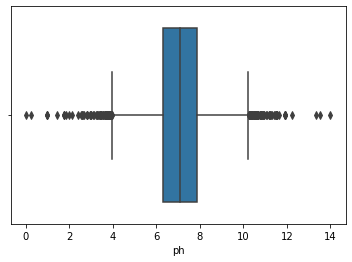

In [ ]:
sns.boxplot(x=data_air['ph'])

Visualisasi Hardness

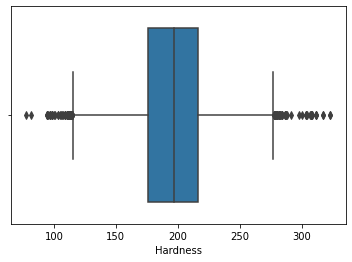

In [ ]:
sns.boxplot(x=data_air['Hardness'])

Visualisasi Solids

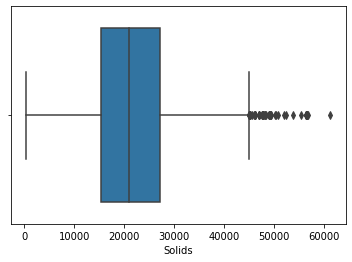

In [ ]:
sns.boxplot(x=data_air['Solids'])

Visualisasi Chloramines

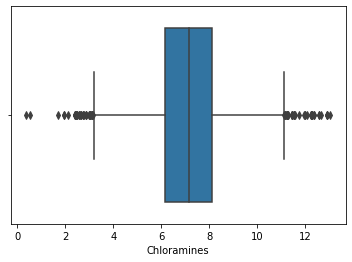

In [ ]:
sns.boxplot(x=data_air['Chloramines'])

Visualisasi Sulfate

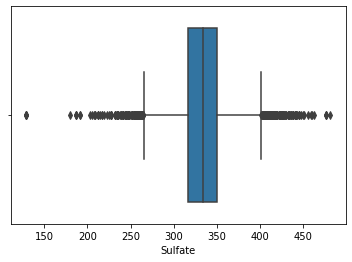

In [ ]:
sns.boxplot(x=data_air['Sulfate'])

Visualisasi Conductivity

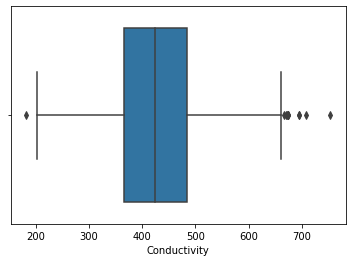

In [ ]:
sns.boxplot(x=data_air['Conductivity'])

Visualisasi Organic_carbon

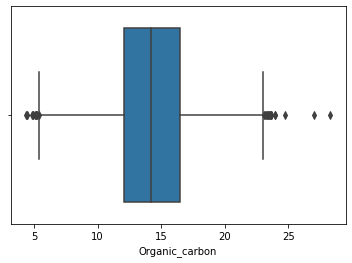

In [ ]:
sns.boxplot(x=data_air['Organic_carbon'])

Visualisasi Trihalomethanes

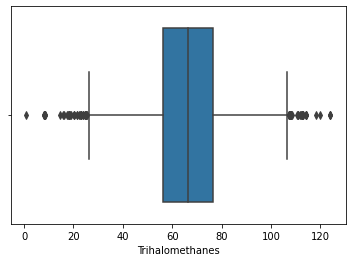

In [ ]:
sns.boxplot(x=data_air['Trihalomethanes'])

Visualisasi Turbidity

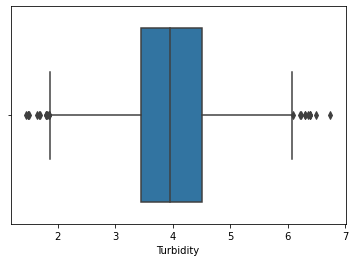

In [ ]:
sns.boxplot(x=data_air['Turbidity'])

##### IQR  
Pada visualisasi data terlihat ada outliers. Maka digunakan metode IQR untuk mengatasinya.

In [ ]:
Q1 = data_air.quantile(0.25)
Q3 = data_air.quantile(0.75)
IQR=Q3-Q1
data_air=data_air[~((data_air<(Q1-1.5*IQR))|(data_air>(Q3+1.5*IQR))).any(axis=1)]
 
# Cek ukuran dataset setelah kita drop outliers
data_air.shape

(3217, 10)

#### Univariate Analysis

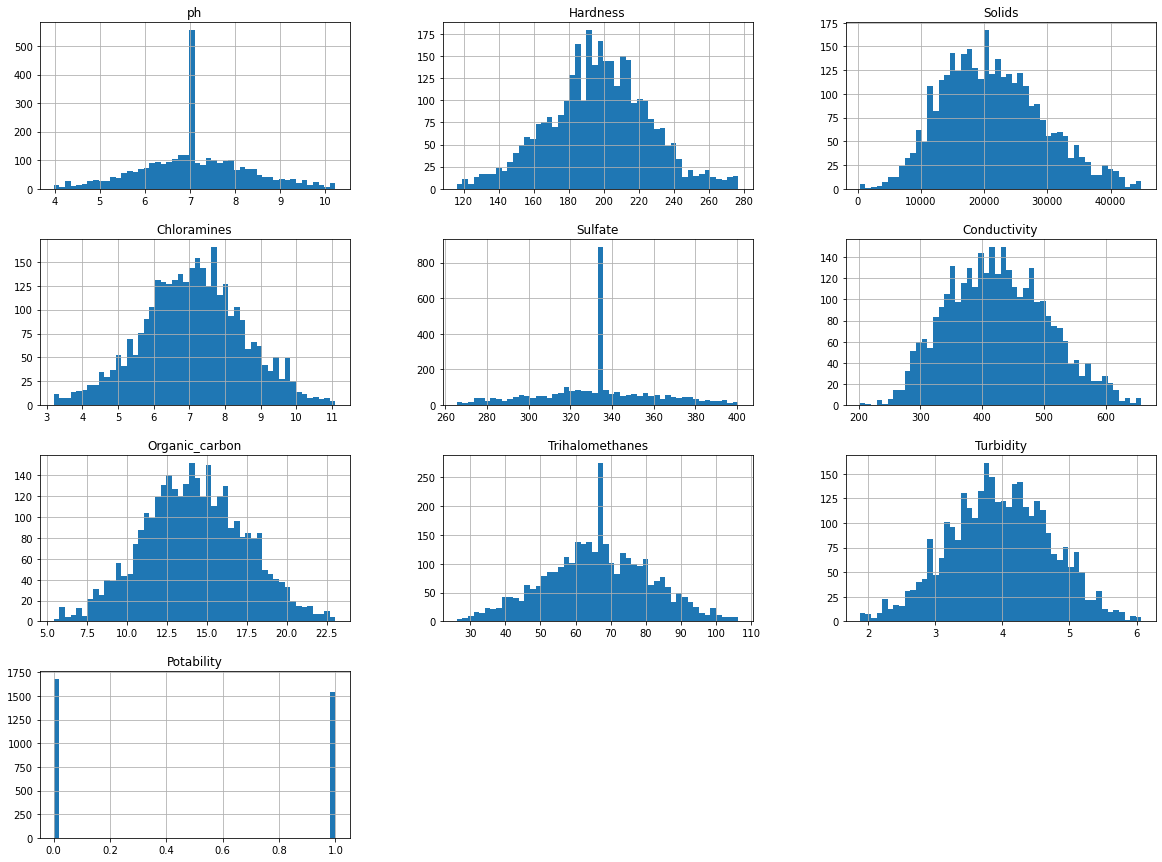

In [ ]:
data_air.hist(bins=50, figsize=(20,15))
plt.show()

#### Multivariate Analysis

Mengamati hubungan antar fitur dengan skor relasi.

Text(0.5, 1.0, 'Correlation Matrix ')

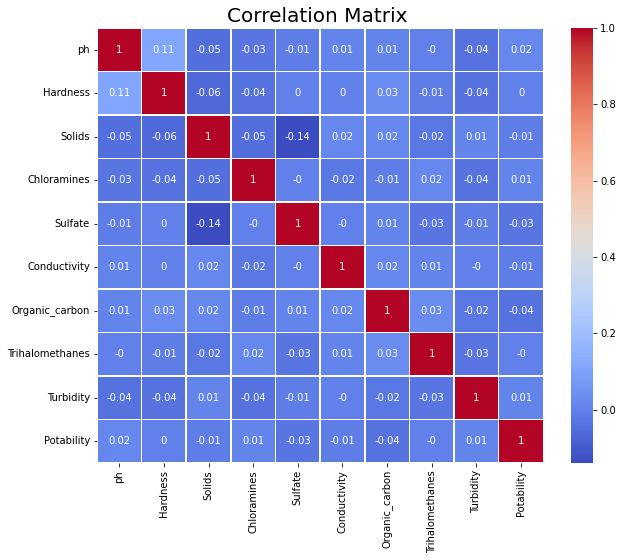

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = data_air.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix ", size=20)

Dilihat dari correlation matrix, masing-masing fitur tidak berkorelasi langsung dengan Potability. Jadi dilanjutkan dengan mempertahankan semua fitur.

## Data Preparation
Setelah membersihkan data dengan menghilangkan *missing value*, menyeimbangkan potability, dan mengatasi *outlierss* dengan IQR dilanjutkan dengan membagi data latih dan data uji.

### Train-Test-Split
Membagi dataset dengan komposisi 80:20

In [ ]:
X = data_air.drop(["Potability"],axis =1)
y = data_air["Potability"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 3217
Total # of sample in train dataset: 2573
Total # of sample in test dataset: 644


## Model Development


### Random Forest
Menggunakan ***RandomForestClassifier*** karena konteks dari data adalah klasifikasi.

In [ ]:
RF = RandomForestClassifier(n_estimators=100, max_depth=13, random_state=55)
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=55, verbose=0,
                       warm_start=False)

## Evaluasi dengan Classification Report

Evaluasi menggunakan metrik Classification Report.  Classification Report dapat menunjukkan nilai dari *precission, recall, f1-score* dan *accuray* yang mana jika ketiga nilai tersebut semakin mendekati 1 maka semakin baik juga model yang dibangun.

In [ ]:
y_pred_test = RF.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.86      0.82       331
           1       0.83      0.73      0.78       313

    accuracy                           0.80       644
   macro avg       0.80      0.80      0.80       644
weighted avg       0.80      0.80      0.80       644



Prediksi dengan menggunakan 50 data test.

In [ ]:
prediksi = X_test.iloc[:50].copy()
pred_dict = {'y_true':y_test[:50]}
pred_dict['prediksi'] = RF.predict(prediksi)
 
sum_test = pd.DataFrame(pred_dict)
sum_test.head(10)

,y_true,prediksi
1067,0,0
598,0,0
96,0,0
1899,1,0
280,1,1
3128,1,1
699,1,1
1133,1,1
1987,1,1
3263,1,1


Menghitung jumlah prediksi yang benar.

In [ ]:
sum_test = sum_test.index

true_RF = 0

j = 0
for i in sum_test:
    if (pred_dict['y_true'][i] == pred_dict['prediksi'][j]).all():
      true_RF += 1
    j+=1

print('true_RF = ', true_RF)

true_RF =  43


Prediksi dengan 50 y_test, didapatkan bahwa Random Forest dapat memprediksi 44 sampel dengan benar. Hal ini berarti bahwa model sudah cukup baik untuk memprediksi kelayakan air.  
Dari model yang dirancang dan evaluasi yang dilakukan, disimpulkan bahwa tidak ada paramater yang paling berpengaruh terhadap kelayakan air dan  model Random Forest cukup baik dan dapat digunakan untuk memprediksi kelayakan air.